# Lecture 15:  Matrix functions (cont.)

## Syllabus
**Week 1:** Matrices, vectors, matrix/vector norms, scalar products & unitary matrices  
**Week 2:** TAs-week (Strassen, FFT, a bit of SVD)  
**Week 3:** Matrix ranks, singular value decomposition, linear systems, eigenvalues  
**Week 4:** Matrix decompositions: QR, LU, SVD + test + structured matrices start  
**Week 5:** Iterative methods, preconditioners, matrix functions
**Week 6:** Advanced topics

## Recap of the previous lecture
- Direct methods for Toeplitz matrices, Gohberg-Semencul formula
- Iterative methods for Toeplitz matrices
- Circulant preconditioners
- Two-dimensional (BTTB) matrices
- Matrix functions: basic concepts

## Today lecture

- Matrix functions and matrix equations

## Matrix functions: definition

One way to define a matrix function $f(A)$ is to use **Jordan canonical form**.

A much more elegant way is to use **Cauchy integral representation:**

$$
    f(A) = \int_{\Gamma} f(z) (zI - A)^{-1} dz,
$$
where $f(z)$ is analytic on and inside a closed contour $\Gamma$ that encloses the spectrum of $A$.

This definition can be generalized to the **operator case.**

## Important matrix functions

- Matrix exponential, used to solve $\frac{dy}{dt} = Ay$ in the "explicit" way, $y = y_0 e^{At}.$
- $\cos(A), \sin(A)$ used to solve wave equation $\frac{d^2 y}{dt^2} + Ay = 0.$
- Sign function, $\mathrm{sign}(A)$, used to compute **spectral projections.**
- Inverse square root $A^{-1/2}$ used in many places, for example, to generate samples from a Gaussian distributions

## Matrix exponential

The matrix exponential is given by the following series:

$$e^A = I + A + \frac{1}{2} A^2 + \frac{1}{3!} A^3 + \ldots$$

Is it a good idea to compute matrix exponential in this form (even in the scalar case?)

This almost assumes a **Krylov method** for the evaluation of $e^{At} y_0,$ by the way.

In [89]:
import numpy as np

x = -10.0 #Point
k = 100 #Number of terms
b = 1.0
x0 = x
for i in range(1, k):
    b += x0
    x0 *= x/(i+1)
    
print 'Error in the exponent:', (b - np.exp(x))/np.exp(x)

Error in the exponent: -2.02829927803e-09


## Series convergence
The series convergence for the matrix exponential can be slow for large $x!$ (and slow for big norm).

What we can do?

## Method 1: Krylov method

We can use the idea of Krylov method: using the Arnoldi method, generate the orthogonal basis in the Krylov subspace,

and compute (it can be used in general for any function)

$$ f(A) \approx f(Q H Q^*) = Q f(H) Q^*,$$

where $H$ is a small upper Hessenberg matrix, for which we can use, for example, the **Schur-Parlett algorithm.**

The convergence of the Krylov method can be quite slow: it is actually a **polynomial approximation** to a function.

And convergence of polynomial approximation to the matrix exponent **can be slow.**

**Idea:** Replace by rational approximation:

## Pade approximations
Matrix exponential is well approximated by **rational function**:  

$$\exp(x) \approx \frac{p(x)}{q(x)},$$

where $p(x)$ and $q(x)$ are polynomials

and computation of a rational function of a matrix is reduced to **matrix-matrix products** and m**matrix inversions**.  

The rational form is also very useful when only a product of a matrix exponential by vector is needed, since  

evaluation reduces to **matrix-by-vector products** and **linear systems solvers**

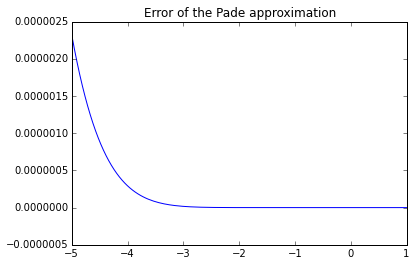

In [94]:
#Computing Pade approximant

import sympy.mpmath
%matplotlib inline
from sympy.mpmath import pade, taylor, polyval
import matplotlib.pyplot as plt
x = np.linspace(-5, 1, 128)
a = taylor(sympy.mpmath.exp, 0, 100) #Taylor series
p, q = pade(a, 6, 6) #Pade approximant
plt.plot(x, polyval(p[::-1], x)/polyval(q[::-1], x) - np.exp(x))
plt.title('Error of the Pade approximation')

## Scaling & squaring algorithm

The "canonical algorithm" also relies on **scaling** of the matrix $A:$

$$\exp(A) = \exp(A/2^k)^{(2^k)},$$

so you:

- Scale the matrix as $B := A/2^k$ to make it norm less than $1$.
- Compute exponent of $C = e^B$ by a **Pade approximant**
- Square $e^A \approx C^{(2^k)}$ in $k$ matrix-by-matrix products.

## Large-scale matrix exponentials

Large-scale matrices obviously do not allow for efficient scaling-and-squaring (need to work with dense matrices), 

thus we can use **Krylov methods** or (better) Rational Krylov methods.

The simplest (yet efficient) approach is based on the so-called **extended Krylov subspaces:**

$$KE(A, b) = \mathrm{Span}(\ldots, A^{-2} b, A^{-1} b, b, A b, A^2 b, \ldots)$$

At each step you add a vector of the form $A w$ and $A^{-1} w$ to the subspace, and orthogonalize the result (**rational Arnoldi method).

I.e., we need only linear system solver for one step, but since the matrix $A$ is fixed, we can **factorize it** once

## Rational Krylov methods

Rational Krylov methods are the most efficient for the computation of matrix functions:

we construct an orthogonal basis in the span,

$$KE(A, b) = \mathrm{Span}(\ldots, A^{-2} b, A^{-1} b, b, A b, A^2 b, \ldots)$$

and compute

$$f(A) \approx Q f(H) Q^*,$$

where $H = Q^* A Q.$

It requires one solver and matrix-by-vector product at each step.

## Application to graph centrality

Important application of matrix exponent is solution of PDes; However, there are other applications, for example, in graph theory, in computation of the **graph centrality**.

This example was taken from [here](http://nbviewer.ipython.org/github/sdrelton/matrix_function_notebooks/blob/master/TheMatrixExponential.ipynb).
Take the following network.


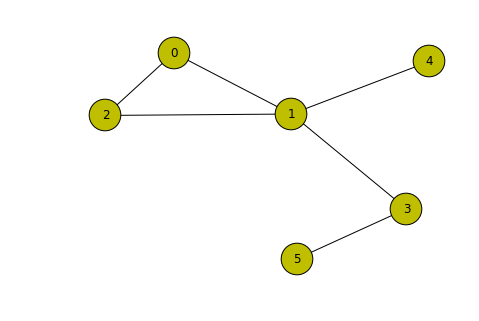

In [95]:
import networkx as nx
import numpy as np
%matplotlib inline
Adj = np.array([[0, 1, 1, 0, 0, 0], 
                [1, 0, 1, 1, 1, 0], 
                [1, 1, 0, 0, 0, 0], 
                [0, 1, 0, 0, 0, 1], 
                [0, 1, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0]])

G = nx.from_numpy_matrix(Adj)
nx.draw(G, node_color='y', node_size=1000, with_labels=True )

One measure of the importance of each node is its <b>centrality</b>.

We can count the number of paths of different lengths from $i$ to $i$,  
and add them up to get **centrality** of the node

$$c(i) = \alpha_1 A_{ii} + \alpha_2 A^2_{ii} + \alpha_3 A^3_{ii} + \cdots,$$

where the coefficients $\alpha_k$ remain to be chosen.  

With $\alpha_k = \frac{1}{k!}$ we get  

$$
    c = \mathrm{diag}(\exp(A))
$$

In [96]:
import scipy.linalg as sla
centralities = np.diag(sla.expm(np.array(Adj, dtype=np.double)))
nodeorder = np.argsort(centralities)[::-1]

print np.array([nodeorder, centralities[nodeorder]])

# Note: This is already built into networkx using the following command
# print nx.communicability_centrality_exp(G)

[[ 1.          0.          2.          3.          4.          5.        ]
 [ 4.44723536  2.86427609  2.86427609  2.36018456  1.71615913  1.59432922]]


## Other matrix functions

Now, let us briefly talk about **other** matrix functions

## Sign function

Sign function is defined as

$$\mathrm{sign}(x) = \begin{cases} 1, \quad x > 0, \\ -1, \quad x < 0. \end{cases}$$

Given a matrix $A = U \Lambda U^*$, it effectively puts all the eigenvalues larger than $0$ to $1$, and all eigenvalues smaller than $0$ to $-1$, thus

$$P = \frac{(I + \mathrm{sign}(A))}{2}$$

is a **projector** onto the subspace spanned by all positive eigenvalues. 

Such projectors can be very useful in **large-scale** eigenvalue computations, when you only need to find a subspace.

## How to compute sign function?

There is a very simple iteration to compute the sign function, namely

$$X_{k+1} = \frac{1}{2} (X_k + X^{-1}_k), X_0 = \alpha A.$$

This iteration converges quadratically to the sign function.

You can also get a polynomial iteration, [proposed by R. Byers](http://www.sciencedirect.com/science/article/pii/0024379587902229)

$$X_{k+1} = \frac{1}{2} X_k (3 I - X_k), \quad X_0 = \alpha A.$$

## Matrix sign function: applications

One of the important applications of the matrix sign function is the solution of the **Algebraic Riccati equation**

$$A^* X + X A - X R X + G = 0,$$

which arises in optimal control and stochastic control.

Solving **ARE** is equivalent to finding a **stable** invariant subspace (i.e., corresponding to the negative eigenvalues)

of the matrix

$$
    C = \begin{bmatrix} A^* & G \\ R & -A \end{bmatrix}.
$$

## Inverse square root of the matrix

The inverse square root of the matrix, $A^{-1/2}$ is also often important.

For example, the multidimensional Gaussian distribution with covariance matrix $A = A^* > 0$ is given by the 

$$e^{A^{-1} x, x},$$

Suppose $x$ is really huge (millions), how we **generate samples**, given a structured matrix $A$?

The simplest algorithm is to generate a normally distributed vector $y$ with $y_i$ from $N(0, 1)$, and then compute

$$x = A^{-\frac{1}{2}} y.$$

The vector $x$ will have the desired distribution.

To compute matrix square root it is very efficient to use **rational Krylov subspaces.**

## Summary 

- (First part): The Schur-Parlett algorithm for matrix functions
- (Second part): More details on the matrix exponential, rational Krylov subspaces

## Advanced topics

In the previous lectures, we have covered the basics of the NLA:

- Concept of floating point and blocking
- Matrix decompositions and how to solve linear systems with them, do eigenvalue computations
- Sparse / structured matrix techiques, matrix functions

Now we will try to discuss more recent "research topics" in linear algebra.

## (Some) of the ongoing research in numerical linear algebra


- Many of the classical problems are solved, but improvements are always possible
- Generalization from the matrix case to the multidimensional case (multilinear algebra, lecture on Thursday this week)
- Using non-standard approximation norms (compressed sensing, L1-norm minimization, why L1-norm minimization gives the sparsest solutions)
- Using block-low-rank approximation to construct efficient solvers for large-scale sparse matrices
- Many others (like solvers for the finite fields).

Today we will talk about large-scale low-rank approximation and maximum-volume principle, and also show 
the connection to the **optimal design problems** that can be traced back to Dijkstra, Fedorov and many others

## Low-rank approximation

Let us go back to the beginning of the course, and consider a large $n \times n$ matrix $A$ of rank-$r \ll n$.

Then, if there is a **non-singular submatrix** of the matrix $A$, we can decompose this matrix as

$$A = C \widehat{A}^{-1} R,$$

where $C$ are some **columns** of $A$, $R$ are some **rows** of $A$ and $\widehat{A}$ is a (non-singular) submatrix on their intersection.


Now suppose the matrix $A$ is only **approximated** with a rank-$r$ matrix, and $\widehat{A}^{-1}$ is **close to singular**.

Then, if we select a wrong submatrix, the error might be huge.

In [102]:
import numpy as np
n = 100
r = 10
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)]
a = np.array(a)

ind = np.arange(r, dtype=np.int)
sbm = a[ind, :][:, ind]
col = a[:, ind]
row = a[ind, :]

approx = col.dot(np.linalg.inv(sbm)).dot(row)
print 'Approximation error:', np.linalg.norm(a - approx)/np.linalg.norm(a)
u, s, v = np.linalg.svd(a)
u = u[:, :r]
s = s[:r]
v = v[:r, :]
approx_svd = u.dot(np.diag(s)).dot(v)
print 'SVD approximation error:', \
np.linalg.norm(a - approx_svd)/np.linalg.norm(a)


Approximation error: 0.0101752773966
SVD approximation error: 7.70489913615e-08


We can actually do much better

Maxvol approximation error: 1.04415987903e-08
SVD approximation error: 4.6714065596e-09


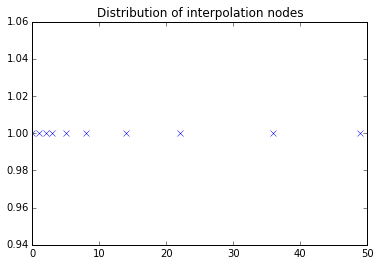

In [103]:
from tt.maxvol import maxvol #Our own ttpy package 
n = 50
r = 10
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)]
a = np.array(a)
u, s, v = np.linalg.svd(a)
u = u[:, :r]
s = s[:r]
v = v[:r, :]
approx_svd = u.dot(np.diag(s)).dot(v)

indu = maxvol(u) #Optimal indices
approx_maxvol = a[:, indu].dot(np.linalg.solve(a[:, indu][indu, :], a[indu, ])) #It is more stable formula
print 'Maxvol approximation error:', np.linalg.norm(a - approx_maxvol)/np.linalg.norm(a)
print 'SVD approximation error:', np.linalg.norm(a - approx_svd)/np.linalg.norm(a)

plt.plot(np.sort(indu), np.ones(r), 'x')
plt.title('Distribution of interpolation nodes')

## What is behind these experiments

Behind this is the **maximum volume principle** in the approximation by low-rank matrices.

The submatrix $\widehat{A}$ has to be selected in such a way that it is volume, defined as 

$$V(\widehat{A}) = | \det (A) | .$$


is larger.

The exact theorem, proved by Goreinov and Tyrtyshnikov, has the form

$$|A - A_{skel}|_{ij} \leq (r + 1) \sigma_{r+1}(A).$$



## Why maximum volume principle?

Let us go back to the **index form** of the low-rank approximation:

$$A_{ij} = \sum_{\alpha=1}^r U_{i \alpha} V_{j \alpha}.$$

Suppose, we fix $V$.

Then we have many equations for few unknowns, let us select just $r$ of those to get a **non-singular system.**

Then, the skeleton decomposition is just the selection of a certain subset of indices $j_k$ of size $r$, 

such that the matrix 

$$ \widehat{V}_{k \alpha} = V_{j_k, \alpha}$$ is non-singular!

This generalizes to the problem of **optimal interpolation**, if we replace a disrete variable by a continious one.

## Optimal interpolation

Suppose you want to approximate a given function $f(x)$ by a linear combination of some **basis functions** $\phi_j(x)$ that we know,

$$f(x) \approx \sum_{j=1}^r c_j \phi_j(x).$$

Variable $x$ can be anything: one-dimensional, two-dimensional, $\ldots$.

This can be formulated as **linear least squares problem.** 

A much simpler approach is to design a set of **interpolation points** 
$x_s, \quad s =1, \ldots, r$ such that

the coefficients can be recovered from **intepolation:**

$$f(x_s) = \sum_{j=1}^r c_j \phi_j(x_s).$$

What are the best interpolation points, given the functions $\phi_j(x)$?

## Leya points

The Leya points are defined as the one that maximize the volume,

$$| \det [\phi_j(x_s)] |.$$

In this case, we get a provable error bound on the approximation:

$$E_{interp} \leq (r + 1) E_{best}.$$

## Back to matrices

If we now replace $x$ by a large set of **discrete indices**, we are left with a large overdetermined system of linear equations


$$f = A c,$$

and we want to find the submatrix in $A$ that corresponds to the **maximal volume.**

How we can do that?

## Maxvol-algorithm


Given an $n \times r$ matrix, find the submatrix of largest **volume** it in.

Use greedy algorithm(!)
- Take some rows, put them in the first $r$. Compute $B = A \widehat{A}^{-1}$
- $B = \begin{pmatrix} I \\
    Z \end{pmatrix}$
- Suppose maximal element in $Z$ is in position $(i,j)$. 
- Swap $i$-th row with $j$-th row.
- Stop if maximal element is less than $(1+\delta)$. 


## Notes on the convergence of the greedy method

We can prove some estimates on the convergence, and some estimates on the **quasioptimality** of the result.

The quasioptimality is based on the fundamental ideas of **supermodular functions.**


## Maxvol and optimal design

In fact, we want to do some measurements on a system at some points, probably to minimize the error we get.

This is a standard problem in **optimal design.**.

## Optimal design 

Suppose we have a "linear experiment" with the design matrix $X:$

$$ y = X \beta + \varepsilon.$$

The rows of the **design matrix** correpond to the particular experiment. (i.e., all possible experiments).

We want to select the "best" experiments, so we need to make as few measurements, as possible, to fit $\beta$.

There are different optimization criteria, and $D$-optimality (maxvol) is one of them.

We can also generalize to arbitrary regression with the help of **Fisher information matrix.**

## Fisher information matrix

In the general case, we are given a random variable $X$ and a set of (unknown) parameters $\theta = [\theta_1, \ldots, \theta_N]$.

We want to measure, what is the information in the measurement of the random variable $X$, were $f$ is the probability function for $X$. The logarithm of $f$ is called **score**, and its second-order moment is the **Fisher information matrix:**

$$I(\theta)_{ij} = E(\frac{\partial^2}{\partial \theta_i \partial \theta_j} \log f(X, \theta) \mid \theta)$$

For a normal distribution, Fisher information boils down to the inverse of the covariance matrix.

## Rectangular case

For the rectangular case (we select more rows than columns), one has to maximize

over all $k \times r$ submatrices of $A$.

$$\det \widehat{A}^* \widehat{A}.$$

It can be applied to such tasks as recommender systems, feature selection, and even iterative methods for linear least squares.

## Summary
This lecture had two parts:

- Matrix functions part
- Maxvol part

## Next lecture

- Compressed sensing, L1-norm minimization, matching pursuits

# Questions?

In [74]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()